In [3]:
pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 15.3 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from etf_transformations import *
import matplotlib.pyplot as plt

In [6]:
base_data = pd.read_csv("../data/preprocessed/separate_stocks_finbert.csv")
base_data.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,AbsReturn_next_day,Sign_next_day,HighVol_next_day,abs_ret_t,vol_5,positive,neutral,negative,finbert_label,finbert_confidence
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,0.012676,1,0,0.056474,NaN,0.156559,0.797031,0.046411,neutral,0.797031
1,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,0.034872,1,1,0.035034,NaN,0.386939,0.569714,0.043347,neutral,0.569714
2,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,0.053446,1,1,0.005144,NaN,0.511469,0.471725,0.016806,positive,0.511469
3,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,0.030955,1,1,0.002587,NaN,0.061889,0.915127,0.022984,neutral,0.915127
4,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,0.026836,0,1,0.009143,0.021677,0.064593,0.896044,0.039362,neutral,0.896044


In [7]:
base_data['row_id'] = base_data.index
base_data.head()

,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,Sign_next_day,HighVol_next_day,abs_ret_t,vol_5,positive,neutral,negative,finbert_label,finbert_confidence,row_id
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,1,0,0.056474,NaN,0.156559,0.797031,0.046411,neutral,0.797031,0
1,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,1,1,0.035034,NaN,0.386939,0.569714,0.043347,neutral,0.569714,1
2,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,1,1,0.005144,NaN,0.511469,0.471725,0.016806,positive,0.511469,2
3,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,1,1,0.002587,NaN,0.061889,0.915127,0.022984,neutral,0.915127,3
4,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,0,1,0.009143,0.021677,0.064593,0.896044,0.039362,neutral,0.896044,4


In [8]:
base_data.columns

Index(['title', 'date', 'stock', 'exchange', 'timestamp_et', 'time_et',
       'date_et', 'news_window', 'sector', 'is_trading_day', 'trading_date',
       'articles_same_stock_day', 'articles_same_sector_day', 'price',
       'price_prev_day', 'price_next_day', 'Return', 'Sign', 'Return_next_day',
       'AbsReturn_next_day', 'Sign_next_day', 'HighVol_next_day', 'abs_ret_t',
       'vol_5', 'positive', 'neutral', 'negative', 'finbert_label',
       'finbert_confidence', 'row_id'],
      dtype='object')

In [9]:
base_data.nunique()

title                       224675
date                        216210
stock                          381
exchange                         2
timestamp_et                216210
time_et                       1439
date_et                       3815
news_window                      3
sector                          11
is_trading_day                   2
trading_date                  2744
articles_same_stock_day         55
articles_same_sector_day       107
price                       156761
price_prev_day              156784
price_next_day              156578
Return                      163267
Sign                             3
Return_next_day             163203
AbsReturn_next_day          163065
Sign_next_day                    2
HighVol_next_day                 2
abs_ret_t                   163148
vol_5                       285581
positive                    234928
neutral                     230267
negative                    235000
finbert_label                    3
finbert_confidence  

In [10]:
# mini test from the transformers website

sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(embeddings, embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\maria\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\maria\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[ 6.76569417e-02  6.34959564e-02  4.87131029e-02  7.93048963e-02
   3.74480709e-02  2.65277619e-03  3.93749177e-02 -7.09846616e-03
   5.93614057e-02  3.15370224e-02  6.00980818e-02 -5.29052354e-02
   4.06067409e-02 -2.59308442e-02  2.98428535e-02  1.12691487e-03
   7.35148937e-02 -5.03818579e-02 -1.22386597e-01  2.37028375e-02
   2.97265276e-02  4.24768776e-02  2.56337691e-02  1.99514348e-03
  -5.69190495e-02 -2.71597989e-02 -3.29035297e-02  6.60248995e-02
   1.19007193e-01 -4.58791330e-02 -7.26214200e-02 -3.25840116e-02
   5.23414016e-02  4.50553410e-02  8.25305004e-03  3.67024243e-02
  -1.39415674e-02  6.53918684e-02 -2.64272075e-02  2.06393175e-04
  -1.36643527e-02 -3.62811014e-02 -1.95043907e-02 -2.89738420e-02
   3.94270532e-02 -8.84090662e-02  2.62423488e-03  1.36713171e-02
   4.83062454e-02 -3.11566181e-02 -1.17329188e-01 -5.11690676e-02
  -8.85287672e-02 -2.18963325e-02  1.42986281e-02  4.44167778e-02
  -1.34816021e-02  7.43392631e-02  2.66382936e-02 -1.98762678e-02
   1.79191

In [12]:
sentences = base_data["title"].astype(str).tolist()

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = model.encode(
    sentences,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)


Batches:   0%|          | 0/5069 [00:00<?, ?it/s]

In [13]:
embeddings_as_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])

In [14]:
embeddings_as_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,-0.018988,0.043675,0.034182,0.051970,0.086746,-0.016687,0.040034,-0.030892,0.023274,0.039689,...,0.044927,-0.013433,-0.041791,-0.007552,-0.043562,0.064962,0.024598,-0.036362,0.005609,0.006723
1,-0.087309,-0.068755,-0.023466,0.034497,-0.035522,0.079823,0.037963,0.032665,-0.055607,-0.031497,...,-0.005445,0.072854,-0.033382,0.050525,-0.021976,-0.061133,0.071026,-0.104717,-0.154968,0.054481
2,0.017416,-0.087886,-0.022821,-0.077017,0.033485,-0.019716,-0.075576,0.126749,-0.002838,0.055836,...,0.022711,0.004054,-0.060530,-0.050457,0.027259,-0.058011,0.011103,-0.155406,0.021580,0.044305
3,-0.032597,0.034642,-0.046380,0.043637,-0.012976,-0.033044,-0.015488,0.073151,-0.089807,-0.068730,...,0.024095,-0.093397,-0.001406,-0.012596,-0.084371,0.017338,0.076390,-0.135631,-0.070295,0.050183
4,-0.066371,-0.025293,0.029038,0.038780,0.018760,-0.057446,-0.041900,0.001107,0.021248,0.004809,...,0.101733,0.006196,-0.056580,0.048957,-0.050295,0.028605,0.017734,-0.075114,-0.104239,0.057186


In [15]:
i, j = 0,1  # indeksy w df

v1 = embeddings_as_df.loc[i, [c for c in embeddings_as_df.columns if c.startswith("emb_")]].values.reshape(1, -1)
v2 = embeddings_as_df.loc[j, [c for c in embeddings_as_df.columns if c.startswith("emb_")]].values.reshape(1, -1)

cosine_similarity(v1, v2)[0, 0]


np.float32(0.11073323)

In [16]:
embeddings_as_df["row_id"] = base_data["row_id"].values

In [17]:
base_with_emb = base_data.merge(embeddings_as_df, on="row_id", how="left", validate="one_to_one")

print(base_with_emb.shape)
base_with_emb.head()

(324380, 414)


,title,date,stock,exchange,timestamp_et,time_et,date_et,news_window,sector,is_trading_day,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,Going Against the Herd,2009-04-29 08:48:00-04:00,A,NYSE,2009-04-29 08:48:00-04:00,08:48:00,2009-04-29,overnight,Health Care,True,...,0.044927,-0.013433,-0.041791,-0.007552,-0.043562,0.064962,0.024598,-0.036362,0.005609,0.006723
1,super-trades - Two 52 week highs and others ab...,2009-06-01 22:15:00-04:00,A,NYSE,2009-06-01 22:15:00-04:00,22:15:00,2009-06-01,overnight,Health Care,True,...,-0.005445,0.072854,-0.033382,0.050525,-0.021976,-0.061133,0.071026,-0.104717,-0.154968,0.054481
2,Skystar Bio-Pharmaceutical Announces Expansion...,2009-07-14 08:14:00-04:00,A,NYSE,2009-07-14 08:14:00-04:00,08:14:00,2009-07-14,overnight,Health Care,True,...,0.022711,0.004054,-0.060530,-0.050457,0.027259,-0.058011,0.011103,-0.155406,0.021580,0.044305
3,The Gold/Silver Ratio From 1300 to 1900...And Now,2009-07-30 18:01:00-04:00,A,NYSE,2009-07-30 18:01:00-04:00,18:01:00,2009-07-30,after_close,Health Care,True,...,0.024095,-0.093397,-0.001406,-0.012596,-0.084371,0.017338,0.076390,-0.135631,-0.070295,0.050183
4,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",2009-08-04 06:45:00-04:00,A,NYSE,2009-08-04 06:45:00-04:00,06:45:00,2009-08-04,overnight,Health Care,True,...,0.101733,0.006196,-0.056580,0.048957,-0.050295,0.028605,0.017734,-0.075114,-0.104239,0.057186


In [18]:
assert base_with_emb["row_id"].is_unique
assert base_with_emb.filter(like="emb_").isna().sum().sum() == 0  # embeddings should exist for all rows


In [19]:
base_with_emb.to_csv("../data/preprocessed/separate_stocks_finbert_with_emb.csv", index=False)


In [ ]:
base_with_emb.to_parquet("../data/preprocessed/separate_stocks_finbert_with_emb.parquet", index=False)


In [ ]:
conf = pd.to_numeric(base_data["finbert_confidence"], errors="coerce")



Communication Services
N: 15201 NaNs: 0
count    15201.000000
mean         0.820691
std          0.138477
min          0.350775
25%          0.740305
50%          0.876448
75%          0.928537
max          0.976492
Name: finbert_confidence, dtype: float64


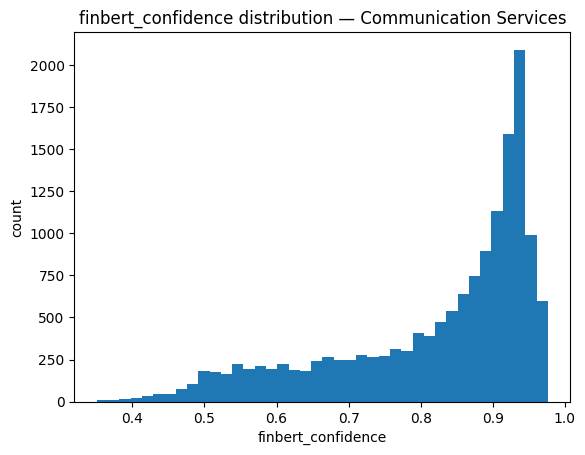


Consumer Discretionary
N: 40478 NaNs: 0
count    40478.000000
mean         0.811593
std          0.145458
min          0.334507
25%          0.724477
50%          0.867547
75%          0.927534
max          0.976251
Name: finbert_confidence, dtype: float64


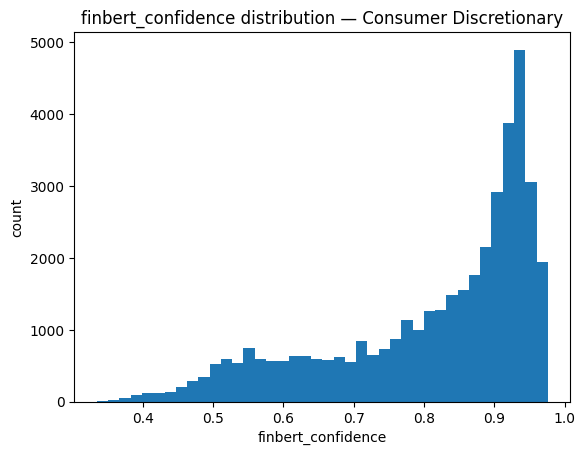


Consumer Staples
N: 30290 NaNs: 0
count    30290.000000
mean         0.816171
std          0.140762
min          0.346027
25%          0.737428
50%          0.870757
75%          0.926132
max          0.976161
Name: finbert_confidence, dtype: float64


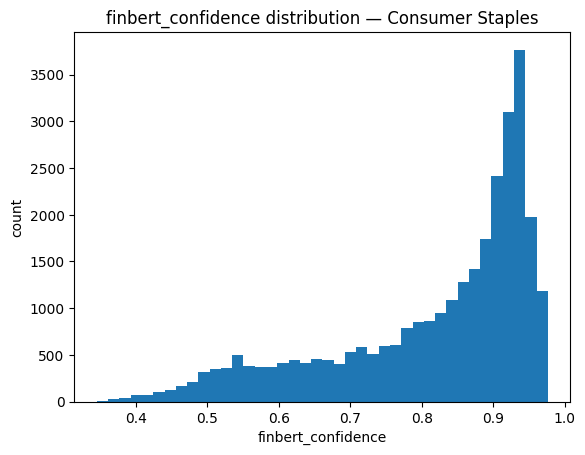


Energy
N: 14203 NaNs: 0
count    14203.000000
mean         0.824846
std          0.142178
min          0.335443
25%          0.751389
50%          0.884018
75%          0.932136
max          0.977208
Name: finbert_confidence, dtype: float64


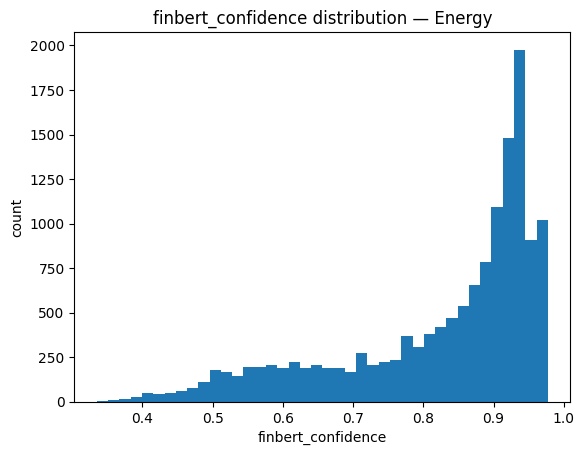


Financials
N: 46926 NaNs: 0
count    46926.000000
mean         0.818329
std          0.143376
min          0.342835
25%          0.737163
50%          0.877809
75%          0.929846
max          0.976507
Name: finbert_confidence, dtype: float64


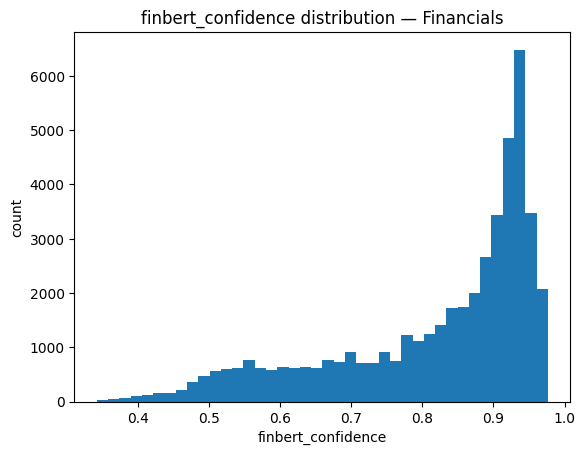


Health Care
N: 50040 NaNs: 0
count    50040.000000
mean         0.806398
std          0.144861
min          0.334090
25%          0.713415
50%          0.858537
75%          0.924578
max          0.976644
Name: finbert_confidence, dtype: float64


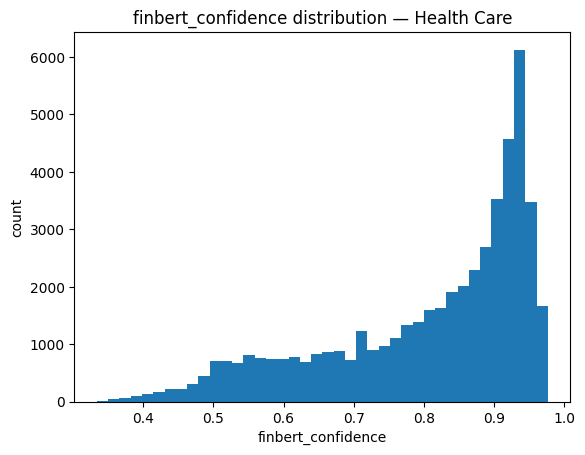


Industrials
N: 41037 NaNs: 0
count    41037.000000
mean         0.808426
std          0.148035
min          0.339316
25%          0.713415
50%          0.865567
75%          0.927955
max          0.976637
Name: finbert_confidence, dtype: float64


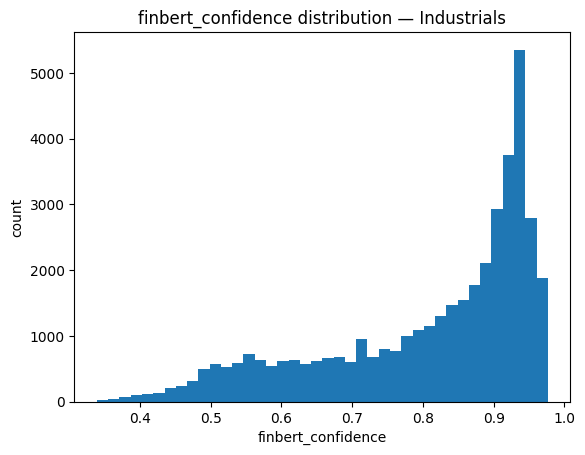


Materials
N: 14212 NaNs: 0
count    14212.000000
mean         0.808488
std          0.148066
min          0.340556
25%          0.716319
50%          0.864711
75%          0.927862
max          0.975705
Name: finbert_confidence, dtype: float64


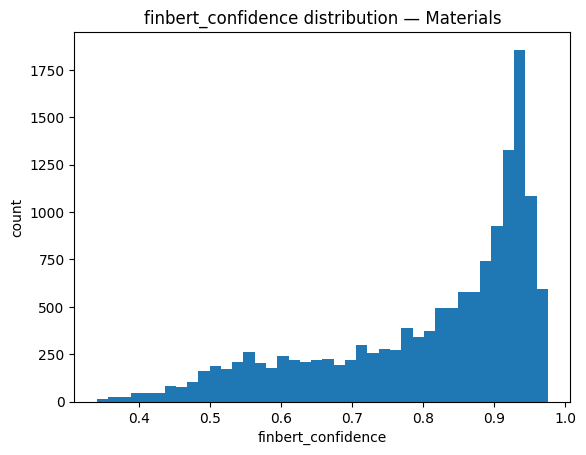


Real Estate
N: 8483 NaNs: 0
count    8483.000000
mean        0.803524
std         0.146865
min         0.341234
25%         0.708453
50%         0.856177
75%         0.923851
max         0.976264
Name: finbert_confidence, dtype: float64


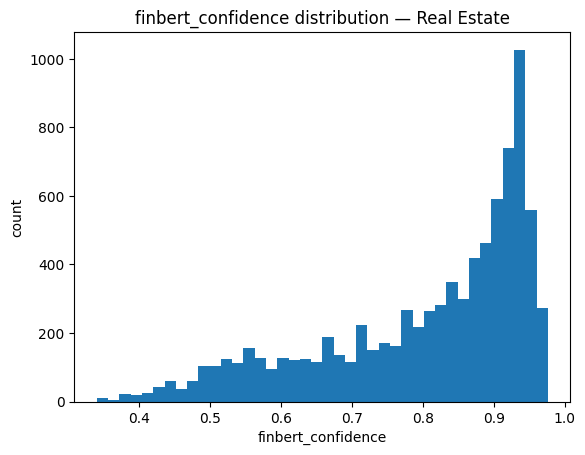


Technology
N: 50212 NaNs: 0
count    50212.000000
mean         0.809840
std          0.148469
min          0.335853
25%          0.716079
50%          0.867369
75%          0.929301
max          0.976099
Name: finbert_confidence, dtype: float64


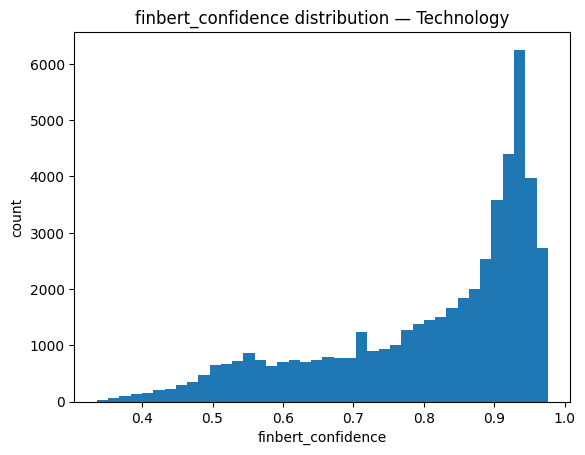


Utilities
N: 13298 NaNs: 0
count    13298.000000
mean         0.798711
std          0.149459
min          0.340339
25%          0.706004
50%          0.850431
75%          0.922260
max          0.976046
Name: finbert_confidence, dtype: float64


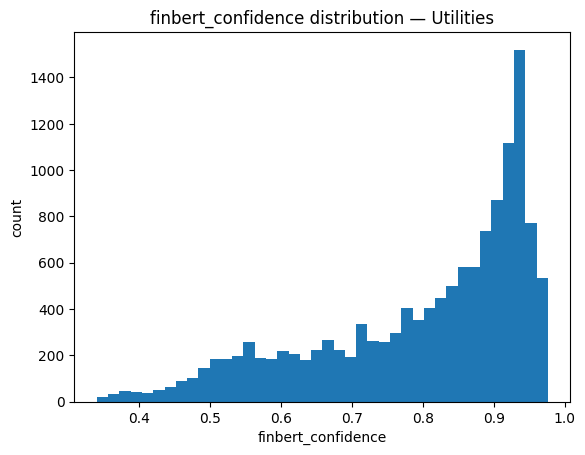

In [21]:
base_data["finbert_confidence"] = pd.to_numeric(base_data["finbert_confidence"], errors="coerce")

for sec, g in base_data.groupby("sector"):
    c = g["finbert_confidence"]
    if c.notna().sum() == 0:
        continue

    print(f"\n{sec}")
    print("N:", len(g), "NaNs:", c.isna().sum())
    print(c.describe())

    plt.figure()
    plt.hist(c.dropna().values, bins=40)
    plt.title(f"finbert_confidence distribution — {sec}")
    plt.xlabel("finbert_confidence")
    plt.ylabel("count")
    plt.show()
